In [1]:
import numpy as np
import matplotlib
%matplotlib notebook
import matplotlib.pyplot as plt
import os
import sys
import pickle
from struct import *
import pandas as pd
import seaborn as sns
import mixture
sns.set_style("white")
import warnings
warnings.filterwarnings("ignore")
import collections
from math import pi, cos, sin, cosh, tanh
from scipy.spatial.transform import Rotation as Rot

## Check that the duration of the full gaze data aligns with the duration of the full gaze video used in tagging errors. (varjo only)

In [2]:
# First check that the gaze data is approximately the same length (in seconds) as the duration of the
#  corresponding full gaze video.

# Load durations of original varjo gaze videos
gaze_vid = pd.read_csv('/home/s202576/thesis_spring2022/NN/data_prep/min_mean_luminance_roc_varjo.csv')
gaze_vid = gaze_vid[gaze_vid.type=='full']
participants = gaze_vid.subID.unique()

In [3]:
del gaze_vid['Unnamed: 0']
gaze_vid.head()

,HMD,task,subID,type,lum_path,dur(s),min_lum_roc,min_lum_frame,min_lum_time(s)
0,varjo,cereal,P14,full,/data/AMPs/second-round/avg-lum-per-frame/P14_...,172.733166,-0.621721,206.0,6.866660
2,varjo,cereal,P23,full,/data/AMPs/second-round/avg-lum-per-frame/P23_...,188.033152,-0.459796,201.0,6.699994
4,varjo,cereal,P19,full,/data/AMPs/second-round/avg-lum-per-frame/P19_...,137.433200,-0.376091,174.0,5.799994
6,varjo,cereal,P2,full,/data/AMPs/second-round/avg-lum-per-frame/P2_c...,121.699882,-0.389706,193.0,6.433327
8,varjo,cereal,P9,full,/data/AMPs/second-round/avg-lum-per-frame/P9_c...,123.899880,-0.535024,210.0,6.999993


In [4]:
# Load relevant varjo gaze datasets
cereal = pd.read_csv('/data/Isabella/thesis_spring2022/AMPs2_varjo/cereal_all.csv')
cereal['task'] = 'cereal'
sandwich = pd.read_csv('/data/Isabella/thesis_spring2022/AMPs2_varjo/sandwich_all.csv')
sandwich['task'] = 'sandwich'
gaze_data = pd.concat([cereal, sandwich])
gaze_data = gaze_data[['subID', 'task', 'raw_timestamp', 'time(s)']]
gaze_data['flag'] = False
gaze_data.loc[gaze_data[gaze_data.subID.isin(participants)].index,'flag'] = True
gaze_data = gaze_data[gaze_data.flag]

In [5]:
gaze_data.head()

,subID,task,raw_timestamp,time(s),flag
0,P2,cereal,1.000006e+18,-0.002951,True
1,P2,cereal,1.000006e+18,0.002047,True
2,P2,cereal,1.000006e+18,0.007046,True
3,P2,cereal,1.000006e+18,0.012046,True
4,P2,cereal,1.000006e+18,0.017048,True


In [6]:
# Add length of gaze data (in seconds) to gaze video df
gaze_vid['data_dur(s)'] = 0.0
for t in gaze_vid.task.unique():
    for p in gaze_vid[gaze_vid.task==t].subID.unique():
        t_max = gaze_data.loc[(gaze_data.task==t) & (gaze_data.subID==p), 'time(s)'].max()
        gaze_vid.loc[(gaze_vid.subID==p) & (gaze_vid.task==t),'data_dur(s)'] = t_max

In [7]:
missing = gaze_vid.loc[gaze_vid['data_dur(s)']==0.0, 'subID']
assert len(missing) == 0, "Missing corresponding gaze data for participants "+str(missing.values)

In [16]:
# Calculate difference in duration between gaze data (s) and gaze videos (s)
gaze_vid['diff(s)'] = gaze_vid['dur(s)']-gaze_vid['data_dur(s)']
# percent longer gaze data is from vid
gaze_vid['percent_diff'] = gaze_vid['diff(s)']/gaze_vid['data_dur(s)']*100 

In [17]:
gaze_vid[gaze_vid.subID=='P21'].head()

,HMD,task,subID,type,lum_path,dur(s),min_lum_roc,min_lum_frame,min_lum_time(s),data_dur(s),diff(s),percent_diff
12,varjo,cereal,P21,full,/data/AMPs/second-round/avg-lum-per-frame/P21_...,173.599832,-0.526452,890.0,29.666638,173.607623,-0.007791,-0.004488


In [10]:
#check = gaze_vid.loc[gaze_vid['diff(s)']<0.0, 'subID']
#assert len(check) == 0, f"The following participants have gaze data longer than gaze video: {check}"

In [11]:
# remove the outlier (P21 sandwich)
gaze_vid = gaze_vid.drop(gaze_vid[gaze_vid.subID=='P21'][gaze_vid.task=='sandwich'].index)

In [12]:
# Calculate the stats of difference (in seconds) between the corresponding videos and gaze datas
print('cereal')
temp = gaze_vid[gaze_vid.task=='cereal']
print(temp['diff(s)'].describe())
print("median",temp['diff(s)'].median())

cereal
count    17.000000
mean     -0.008855
std       0.008979
min      -0.024462
25%      -0.015154
50%      -0.007791
75%      -0.002989
max       0.004298
Name: diff(s), dtype: float64
median -0.0077907241711443476


In [13]:
# Calculate the stats of difference (in seconds) between the corresponding videos and gaze datas
print('sandwich')
temp = gaze_vid[gaze_vid.task=='sandwich']
print(temp['diff(s)'].describe())
print("median",temp['diff(s)'].median())

sandwich
count    16.000000
mean     -0.008967
std       0.006283
min      -0.022889
25%      -0.011401
50%      -0.006981
75%      -0.005416
max       0.002607
Name: diff(s), dtype: float64
median -0.006981134882778406


In [18]:
gaze_vid.head()

,HMD,task,subID,type,lum_path,dur(s),min_lum_roc,min_lum_frame,min_lum_time(s),data_dur(s),diff(s),percent_diff
0,varjo,cereal,P14,full,/data/AMPs/second-round/avg-lum-per-frame/P14_...,172.733166,-0.621721,206.0,6.866660,172.757628,-0.024462,-0.014159
2,varjo,cereal,P23,full,/data/AMPs/second-round/avg-lum-per-frame/P23_...,188.033152,-0.459796,201.0,6.699994,188.056043,-0.022891,-0.012173
4,varjo,cereal,P19,full,/data/AMPs/second-round/avg-lum-per-frame/P19_...,137.433200,-0.376091,174.0,5.799994,137.429682,0.003519,0.002560
6,varjo,cereal,P2,full,/data/AMPs/second-round/avg-lum-per-frame/P2_c...,121.699882,-0.389706,193.0,6.433327,121.715036,-0.015154,-0.012450
8,varjo,cereal,P9,full,/data/AMPs/second-round/avg-lum-per-frame/P9_c...,123.899880,-0.535024,210.0,6.999993,123.907213,-0.007332,-0.005918


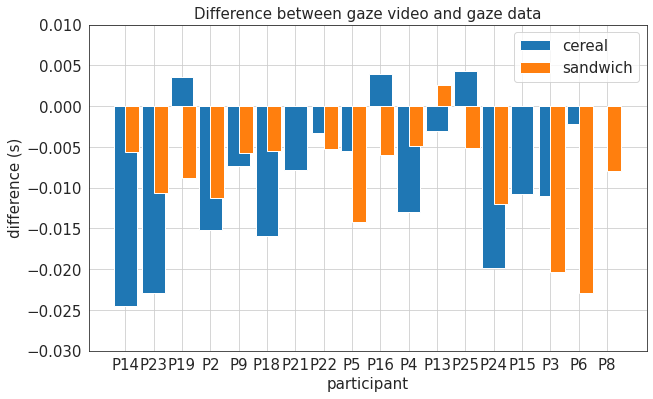

In [23]:
%matplotlib inline
plt.figure(figsize=(10,6))
plt.bar(gaze_vid[gaze_vid.task=='cereal'].subID, gaze_vid[gaze_vid.task=='cereal']['diff(s)'], label = 'cereal')
plt.bar(gaze_vid[gaze_vid.task=='sandwich'].subID, gaze_vid[gaze_vid.task=='sandwich']['diff(s)'], align='edge',width=0.5,label = 'sandwich')
plt.ylim((-0.03,0.01))
plt.xlabel('participant',fontsize=15)
plt.ylabel('difference (s)',fontsize=15)
plt.title('Difference between gaze video and gaze data',fontsize=15)
plt.legend(fontsize=15)
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
plt.grid()
plt.show()

<IPython.core.display.Javascript object>


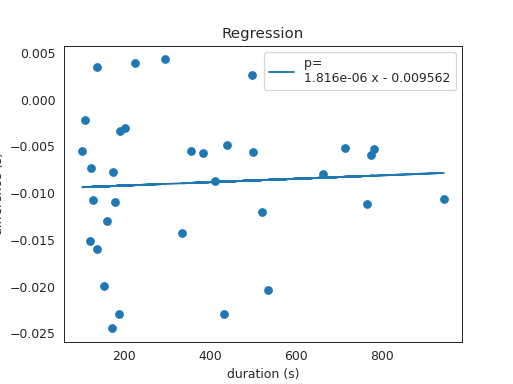

In [15]:
plt.figure()
plt.scatter(gaze_vid['dur(s)'],gaze_vid['diff(s)'])
z = np.polyfit(gaze_vid['dur(s)'],gaze_vid['diff(s)'],1)
p = np.poly1d(z)
plt.plot(gaze_vid['dur(s)'],p(gaze_vid['dur(s)']), label='p='+str(p))
plt.xlabel('duration (s)')
plt.ylabel('difference (s)')
plt.title('Regression')
plt.legend()
#plt.plot([0,1000],[0,1])
plt.show()

In [16]:
(1-p[0])*30

30.286869327519046

In [17]:
p

poly1d([ 1.81644822e-06, -9.56231092e-03])

In [18]:
# save csv
gaze_vid.to_csv('/home/s202576/thesis_spring2022/NN/data_prep/gaze_dur_diff.csv')
gaze_vid.to_csv('/data/Isabella/thesis_spring2022/offsets/gaze_dur_diff.csv')

In [4]:
df = pd.read_csv('/home/s202576/thesis_spring2022/NN/data_prep/gaze_dur_diff.csv')
for subID in df.subID.unique():
    for task in df[df.subID==subID].task.unique():
        print(subID, task)

P14 cereal
P14 sandwich
P23 cereal
P23 sandwich
P19 cereal
P19 sandwich
P2 cereal
P2 sandwich
P9 cereal
P9 sandwich
P18 cereal
P18 sandwich
P21 cereal
P22 cereal
P22 sandwich
P5 cereal
P5 sandwich
P16 cereal
P16 sandwich
P4 cereal
P4 sandwich
P13 cereal
P13 sandwich
P25 cereal
P25 sandwich
P24 cereal
P24 sandwich
P15 cereal
P3 cereal
P3 sandwich
P6 cereal
P6 sandwich
P8 sandwich


<IPython.core.display.Javascript object>


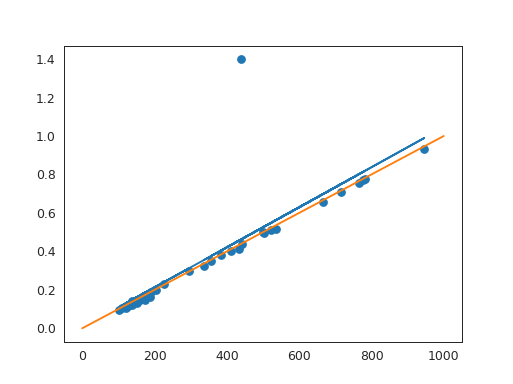

In [36]:
plt.figure()
plt.scatter(gaze_vid['dur(s)'],gaze_vid['diff(s)'])
z = np.polyfit(gaze_vid['dur(s)'],gaze_vid['diff(s)'],1)
p = np.poly1d(z)
plt.plot(gaze_vid['dur(s)'],p(gaze_vid['dur(s)']))
plt.plot([0,1000],[0,1])
plt.show()

In [34]:
(1-p[0])*30

29.858371217243594

In [ ]:
30.000029 29.970030

In [39]:
print(gaze_vid.loc[gaze_vid['dur(s)'].argmax(),'subID'],gaze_vid.loc[gaze_vid['dur(s)'].argmax(),'task'])

P13 cereal
